In [1]:
import pandas as pd
import env
import acquire
import prepare
from scipy import stats
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import PredictionError
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math

# Zillow Home Value Prediction Project 
    Christopher Curran

# Project Overview & Goals:
    
    To create a DataFrame from Zillow dataset that can be used to predict the value of a home though a regression model. I will be utilizating visualization, statistical testing, top drivers for home value, and data preperation to determine the best model to use. For train, validate, and test I have set the seed to 123.

# Executive Summary:


* The top drivers for home value are sqft_living, bathrooms, and bedrooms.
* Baseline model has RMSE -487199.82 compared to Actual using median taxvalue in training set
* MLP Regression model has RMSE -370766.21 compared to Actual using median taxvalue in training set
* MLP is the best model with an improvement of 116,433.61 compared to baseline model

# Data Acquistion
    

In [2]:
# Load the data from acquire.py using get_zillow_data()
df = acquire.get_zillow_data()

Reading from csv file...


In [3]:
# Create deep copy of original df and reassign it to df_prep
df_prep = df.copy(deep=True)

# Data Cleaning

Removed the top 4 outliers from taxvalue and imputed NaN values using most frequenct values.

In [4]:
# Data cleaning/wrangling/outlier detection/removal
train, validate, test = prepare.wrangle_zillow(df_prep)

# EDA

## Goals:
* Used train split for visulisations is 8102 unique houses with a total of 14 features and 1 target (taxvalue)
* Create correlation matrix to see which features are correlated with each other 
* Create corraltion heatmap to see which features are correlate with target (taxvalue)
* Create pairplot for ("bedroom, bathrooms,	sqft_living, and sqft_lot) to see correlations to Target (taxvalue)
* Determine corralation features to target with statistial testing 

## Summery:
  * Top 3 features are bedroom, bathrooms, and sqft_living
  * Pearsonr confirms that bedroom and bathrooms are correlated with taxvalue (sqft_living, 0.562445, sqft_lot, 0.527076)
  * bathrooms 0.491879, bedrooms, 0.210934)


## Question:
    What is the correlation between the target (taxvalue) and the features?

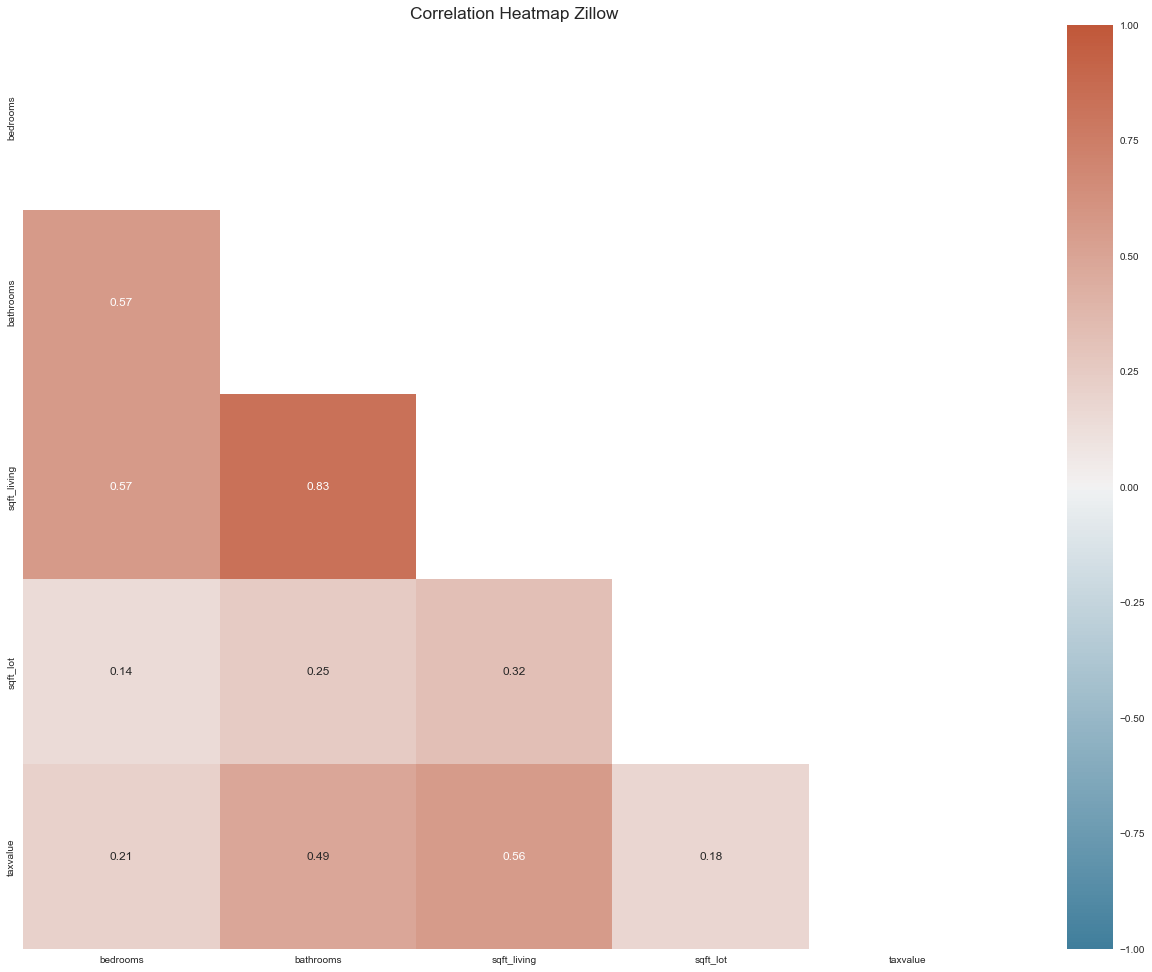

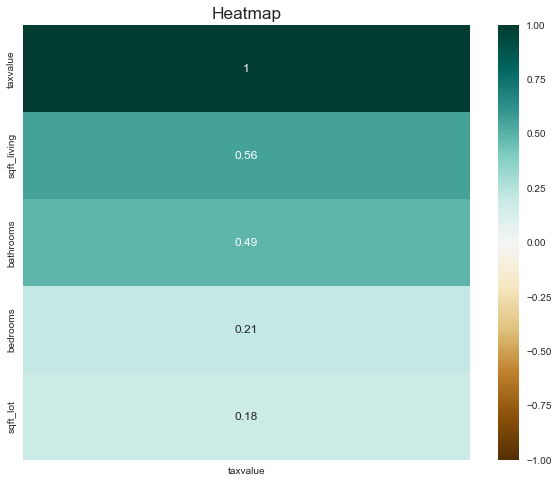

In [15]:
# Callable function to create a correlation heatmap from prepare.py
prepare.corrstatsgraphs4(train)

* Bathroom have a strong correlation (0.83) to the sqft_living and have a strong correlation (0.49) to the taxvalue
* Bedrooms have a strong correlation (0.21) to the taxvalue and have a strong correlation (0.57) to the sqft_living
* sqft_living a strong correlation (0.52) to the taxvalue

# Hypothesis: Alpha 0.05
    H0: There is no correlation between sqft_living and the target (taxvalue)
    H1: There is a correlation between sqft_living and the target (taxvalue) 

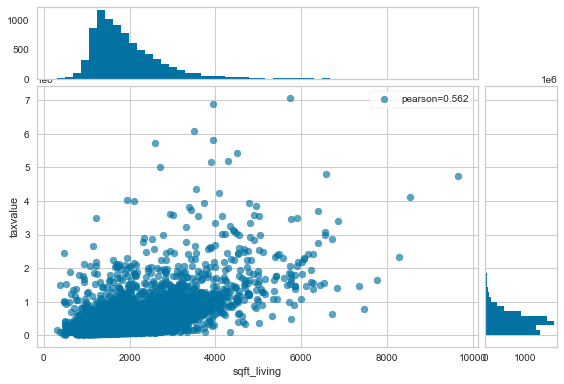

r = 0.5624, p = 0.0000


In [18]:
# Visualize using yellowbrick library & statsmodels
visualizer = JointPlotVisualizer(columns=['sqft_living', 'taxvalue'], line_kws={'color': 'red'})
visualizer.fit_transform(train)
visualizer.show()
r, p = stats.pearsonr(train.sqft_living, train.taxvalue)
print(f'r = {r:.4f}, p = {p:.4f}')

Reject Null Hypothesis:
    There is a correlation between sqft_living and the target (taxvalue)

# Hypothesis:
    H0: There is no correlation between bathrooms and the target (taxvalue)
    H1: There is a correlation between bathrooms and the target (taxvalue)


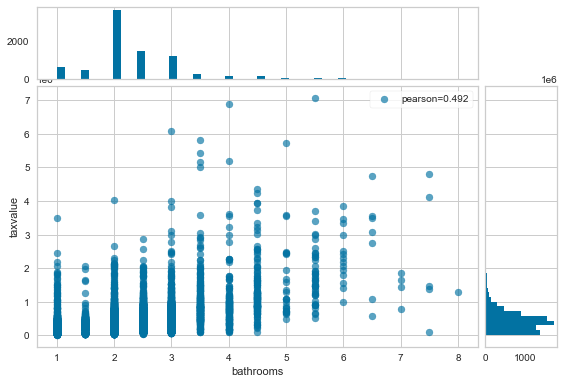

r = 0.4919, p = 0.0000


In [19]:
visualizer = JointPlotVisualizer(columns=['bathrooms', 'taxvalue'])
visualizer.fit_transform(train)
visualizer.show()
r, p = stats.pearsonr(train.bathrooms, train.taxvalue)
print(f'r = {r:.4f}, p = {p:.4f}')

Reject Null Hypothesis:
    There is a correlation between bathrooms and the target (taxvalue)

# Hypothesis:
    H0: There is no correlation between bedrooms and the target (taxvalue)
    H1: There is a correlation between bedrooms and the target (taxvalue)

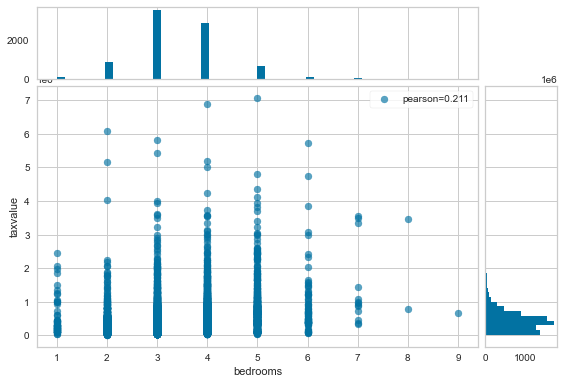

r = 0.2109, p = 0.0000


In [20]:
visualizer = JointPlotVisualizer(columns=['bedrooms', 'taxvalue'])
visualizer.fit_transform(train)
visualizer.show()
r, p = stats.pearsonr(train.bedrooms, train.taxvalue)
print(f'r = {r:.4f}, p = {p:.4f}')

Reject Null Hypothesis:
    There is a correlation between bedrooms and the target (taxvalue)

In [14]:
# Pearsonr Correlation test to check the correlation between the features and the target 
# (closer to 1 means more correlated to the target taxvalue)
pd.DataFrame.corrwith(train[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']], train.taxvalue, method='pearson').sort_values(ascending=False)

sqft_living    0.562445
bathrooms      0.491879
bedrooms       0.210934
sqft_lot       0.176980
dtype: float64

Feature Selection using Desision Tree Regression and yellowbrick

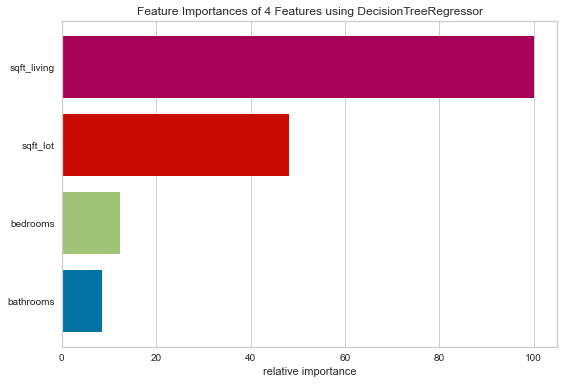

<AxesSubplot:title={'center':'Feature Importances of 4 Features using DecisionTreeRegressor'}, xlabel='relative importance'>

In [13]:
# Confirm the feature importance of the model with the 4 top features to target taxvalue using DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=123)
viz = FeatureImportances(model)
viz.fit(train[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']], train.taxvalue)
viz.show()

# Preprocessing:

In [ ]:
# convert features to category
train, validate, test = prepare.data(train, validate, test)

In [ ]:
# scales train, validate, test using prepare.py and RobustScaler to soften the outliers
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test, return_scaler=False)

In [ ]:
# splits train, validate, test into X and y using prepare.py
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.X_y_split(train_scaled, validate_scaled, test_scaled)

# Modeling:

In [ ]:
# create predictions df for model performance metrics using target and baseline using median of target
predictions_1 = pd.DataFrame({'actual': validate.taxvalue, 'Baseline': validate.taxvalue.median()})

In [ ]:
# concatenate model performance metrics to predictions_1
pd.concat([
    predictions_1.apply(lambda col: r2_score(predictions_1.actual, col)).rename('r2'),
    predictions_1.apply(lambda col: mean_squared_error(predictions_1.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
Baseline,-0.036442,2.373637e+11,487199.822828
Ridge,0.356075,1.474702e+11,384018.548622
Linear,0.331793,1.530314e+11,391192.230998
MLP,0.399752,1.374676e+11,370766.219448


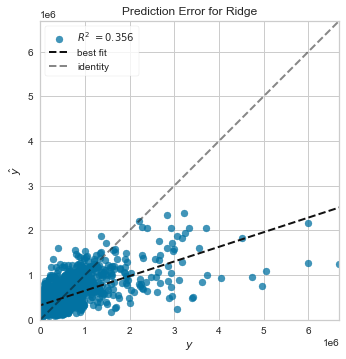

<AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# using yellowbrick library to visualize the model performance metrics 
model = Ridge(alpha= 1, max_iter=2000, solver= 'lsqr')
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
predictions_1['Ridge'] = model.predict(X_validate) # performance matrices R2, RMSE, and MSE
visualizer.score(X_validate, y_validate)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


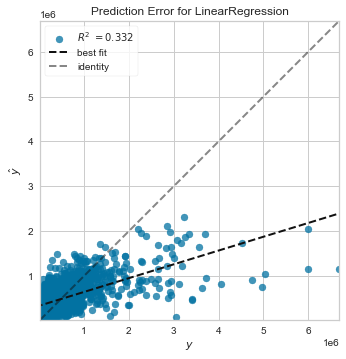

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# using yellowbrick library to visualize the model performance metrics 
model =  LinearRegression(fit_intercept=True, n_jobs=-1, positive=True)
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
predictions_1['Linear'] = model.predict(X_validate) # performance matrices R2, RMSE, and MSE
visualizer.score(X_validate, y_validate)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  warnings.warn(


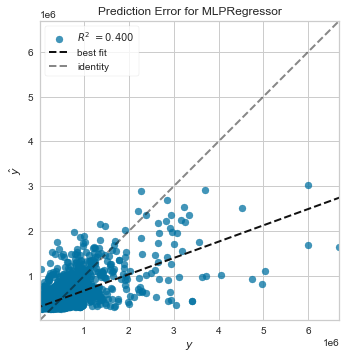

<AxesSubplot:title={'center':'Prediction Error for MLPRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# using yellowbrick library to visualize the model performance metrics 
model =  MLPRegressor(max_iter=20000)
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
predictions_1['MLP'] = model.predict(X_validate) # performance matrices R2, RMSE, and MSE
visualizer.score(X_validate, y_validate)  # Evaluate the model on the test data
visualizer.show()  

# Conclusion:
* Baseline model has RMSE -487199.82 compared to Actual using median taxvalue in training set
* MLP Regression model has RMSE -370766.21 compared to Actual using median taxvalue in training set
* MLP is the best model with an improvement of 116,433.61 compared to baseline model

# Additional Comments:
* Due to technical issues with python the get_dummies function was removed due to shape error it only effects the final report not the rough draft.
* Recommend the need to get more data regarding home characteristics i.e. stories and garage_spaces